# Final Project: Bag of Words Method (Dog vs Cat Classification)

Hello! Welcome to my final project! Throughout this notebook, I will be exploring and implementing the nortious Bag of Words Method to distinguish pictures between dogs and cats. Based on the method of approach we learned in class, we will organize this project into three parts:
1. Dictionary Learning (Learn Visual Words using Clustering)
2. Encode build Bag of Words vectors for each image
3. Classify (Train and test data using BOWs)
4. Conclusion

There are **two main goal** of this project: 
1. Learning how this method is able to breakdown and analyze pictures using computer vision techniques we have learned in this course in combination of utilizing mathematical tools in the cluster and encode stage
2. The difference in accuarcy of the classification stage of <i>K nearest neighbors vs. Neural Network</i>

As you can most likely already tell, the style of approach that I have choosen to present this project is inspired by you, the professor :)! I geniuelly enjoyed the technique in which you presented the programming assignments and it being geared towards as a tutorial so I will do the same. 

Anything that has not been coded, made, or derived by me will be cited throughout this tutorial.

<b><i>With all of that being said, lets get to workin!</i></b>

Text(0.5, 1.0, 'My Dog Wesley')

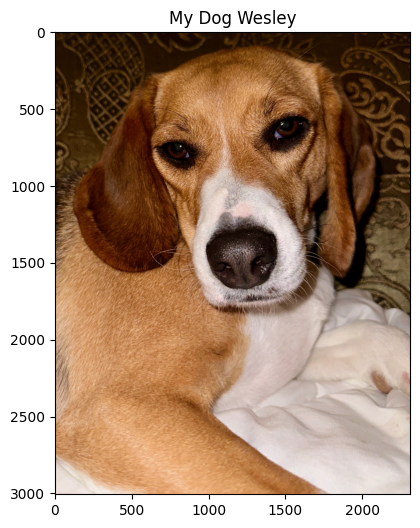

In [12]:
#Run this code to make sure all imports are loaded correctly w/o error 
#Picture of my dog should load
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
# from cyvlfeat.hog import hog

#load_image() function from programming assignments
def load_image(filepath):
    img = Image.open(filepath)
    return (np.asarray(img).astype(float)/255)[:, :, :3]

plt.figure(figsize=(12, 6))
plt.imshow(load_image("./pictures/mypup.jpeg"))
plt.title("My Dog Wesley")

# P.1 Dictionary Learning (Learn Visual Words using Clustering)


TypeError: Invalid shape (0,) for image data

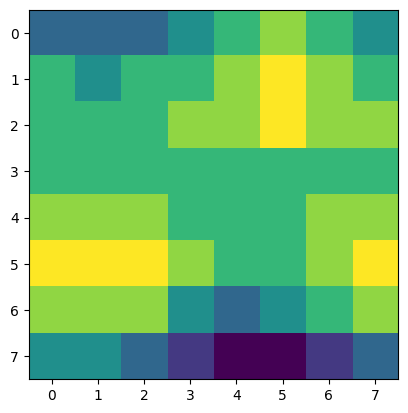

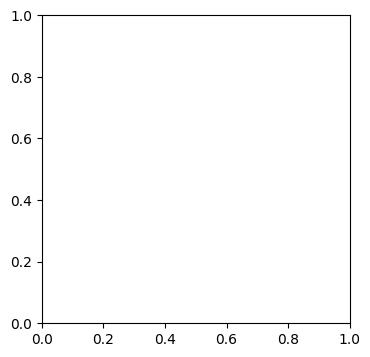

In [28]:
#Switching Image back to Grayscale 
def load_image(filepath):
    img = Image.open(filepath).convert('L')  
    return (np.asarray(img).astype(float) / 255)


image = load_image("./pictures/mypup.jpeg")

def compute_hog(image):
    #Intializing our initial variables: cells, bins, width
    C = 8
    B = 9
    w = 180/B
    
    hog_descriptor = list()
    
    # First Compute Derivates in X and Y direction using central difference
    Ix = np.zeros_like(image)
    Iy = np.zeros_like(image)
    
    Ix[:, 1:-1] = image[:, 2:] - image[:, :-2]
    Iy[1:-1, :] = image[2:, :] - image[:-2, :]


    #Compute "mu constant" and "theta"
    mu = np.sqrt(np.square(Ix) + np.square(Iy))
    theta = (180 / np.pi) * (np.arctan2(Iy, Ix) % np.pi)

    #Getting our "sliding window" of CxC
    cell_x = image.shape[1] // C
    cell_y = image.shape[0] // C

    for i in range(cell_y):
        for j in range(cell_x):
            cell_magnitude = mu[i*C:(i+1)*C, j*C:(j+1)*C]
            cell_orientation = theta[i*C:(i+1)*C, j*C:(j+1)*C]
            histogram = np.zeros(B)
            
            for orientation, magnitude in zip(cell_orientation.flatten(), cell_magnitude.flatten()):
                bin_index = ((orientation // w) - (1/2)) % B
                histogram[int(bin_index)] = magnitude  
            hog_descriptor.append(histogram)

    return np.array(hog_descriptor)
            
    

    

hog_features = compute_hog(image)

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
)

plt.figure(figsize=(10, 4))
plt.imshow(hog_features, interpolation='nearest')

plt.figure(figsize=(12, 12))
plt.imshow(hog_image, cmap="gray")